<a href="https://colab.research.google.com/github/itaborai83/ecd221-DW-chinook/blob/main/Deep_Learning_Elei%C3%A7%C3%B5es_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib numpy pandas requests basemap pyarrow pyshp duckdb lowess ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 38.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.2 MB/s eta 0:00:00
  Created wheel for lowess: filename=lowess-1.0.3-py3-none-any.whl size=6190 sha256=94757152043c71e248756090dd460497831fd4b843f6a3a75b86e9d8c8900683
  Stored in directory: /root/.cache/pip/wheels/71/09/90/518da6af710a

In [2]:
import math
import os.path
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.scale import LogScale
import requests
import shutil
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import shapefile
import duckdb
import lowess
from sklearn.manifold import Isomap

In [3]:
# Criação dos diretórios de dados
!mkdir -p DATA
!mkdir -p DATA/GIS

# arquivo de resultados da eleição de 2022
# !wget -nc -O DATA/votacao_secao_2022_BR.zip https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2022_BR.zip
!wget -nc -O DATA/votacao_secao_2022_BR.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/votacao_secao_2022_BR.zip

# arquivo com coordenadas geocodificadas das seções eleitorais. Arquivo original possuía cerca de 1/3 de dados não geocodificados
# !wget -nc -O DATA/eleitorado.parquet https://github.com/itaborai83/eleicoes2022/blob/main/eleitorado.parquet?raw=true
# !wget -nc -O DATA/eleitorado.parquet https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/eleitorado.parquet

!wget -nc -O DATA/eleitorado_2022.parquet https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/eleitorado_2022.parquet

# shapefile com o formato do país
# !wget -nc -O DATA/GIS/BR_Pais_2021.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_Pais_2021.zip
!wget -nc -O DATA/GIS/BR_Pais_2021.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/BR_Pais_2021.zip

# shapefile com o formato dos estados
# !wget -nc -O DATA/GIS/BR_UF_2021.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
!wget -nc -O DATA/GIS/BR_UF_2021.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/BR_UF_2021.zip

# extração dos dados da eleição de 2022
!unzip -o DATA/votacao_secao_2022_BR.zip
!rm leiame.pdf
!mv votacao_secao_2022_BR.csv DATA/.

# extração dos shapefiles
!unzip -od DATA/GIS DATA/GIS/BR_Pais_2021.zip
!unzip -od DATA/GIS DATA/GIS/BR_UF_2021.zip

# !ls -alh DATA
# !ls -alh DATA/GIS

--2023-03-27 22:43:16--  https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/votacao_secao_2022_BR.zip
Resolving itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com (itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com)... 16.12.1.62
Connecting to itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com (itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com)|16.12.1.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271292455 (259M) [application/zip]
Saving to: ‘DATA/votacao_secao_2022_BR.zip’

DATA/votacao_secao_ 100%[===================>] 258.72M  16.5MB/s    in 17s     

2023-03-27 22:43:35 (14.9 MB/s) - ‘DATA/votacao_secao_2022_BR.zip’ saved [271292455/271292455]

--2023-03-27 22:43:35--  https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/eleitorado_2022.parquet
Resolving itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com (itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com)... 16.12.2.54
Connecting to itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com (

In [4]:
DADOS_VOTACAO_2022    = "DATA/votacao_secao_2022_BR.csv"
DADOS_ELEITORADO_2022 = "DATA/eleitorado_2022.parquet"
DADOS_BRASIL          = "DATA/GIS/BR_Pais_2021"
DADOS_UFS             = "DATA/GIS/BR_UF_2021"

In [5]:
# leitura dos dados da eleição de 2022
votos22_df = pd.read_csv(DADOS_VOTACAO_2022, sep=";", encoding="latin-1")
# remove colunas não utilizadas. TODO: 
to_be_dropped_22 = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'ANO_ELEICAO', 
    'CD_TIPO_ELEICAO', 
    'NM_TIPO_ELEICAO', 
    'CD_ELEICAO', 
    'DS_ELEICAO', 
    'DT_ELEICAO', 
    'TP_ABRANGENCIA', 
    'CD_CARGO', 
    'SQ_CANDIDATO',
    'SG_UE',
    'NM_UE',
    
]
votos22_df.drop(to_be_dropped_22, axis=1, inplace=True)
votos22_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   NR_TURNO                   int64 
 1   SG_UF                      object
 2   CD_MUNICIPIO               int64 
 3   NM_MUNICIPIO               object
 4   NR_ZONA                    int64 
 5   NR_SECAO                   int64 
 6   DS_CARGO                   object
 7   NR_VOTAVEL                 int64 
 8   NM_VOTAVEL                 object
 9   QT_VOTOS                   int64 
 10  NR_LOCAL_VOTACAO           int64 
 11  NM_LOCAL_VOTACAO           object
 12  DS_LOCAL_VOTACAO_ENDERECO  object
dtypes: int64(7), object(6)
memory usage: 533.7+ MB


In [6]:
resultado22_df = votos22_df.groupby(["NR_TURNO", "SG_UF", "NM_MUNICIPIO", "NR_VOTAVEL", "NM_VOTAVEL"]).sum(["QT_VOTOS"])
resultado22_df.drop(["CD_MUNICIPIO", "NR_ZONA", "NR_SECAO", "NR_LOCAL_VOTACAO"], axis=1, inplace=True)
resultado22_df.sort_values(["NR_TURNO", "SG_UF", "NR_VOTAVEL"], inplace=True)
resultado22_df.reset_index(inplace=True)
resultado22_df.head()

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
0,1,AC,ACRELÂNDIA,12,CIRO FERREIRA GOMES,117
1,1,AC,ASSIS BRASIL,12,CIRO FERREIRA GOMES,44
2,1,AC,BRASILÉIA,12,CIRO FERREIRA GOMES,249
3,1,AC,BUJARI,12,CIRO FERREIRA GOMES,197
4,1,AC,CAPIXABA,12,CIRO FERREIRA GOMES,120


In [7]:
votos22_df.head()

,NR_TURNO,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
0,1,MS,98116,SELVÍRIA,9,157,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1015,CENTRO ADMINISTRATIVO FABIANO MELO (ANTIGA FAC...,"AV. GOIÁS, 556"
1,1,RS,87912,PELOTAS,60,500,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,173,2526,UNIÃO GAÚCHA J. SIMÕES LOPES NETO,"AV. ENGENHEIRO ILDEFONSO SIMÕES LOPES, 531"
2,1,MG,41238,BELO HORIZONTE,35,221,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,129,1180,UTRAMIG,"AVENIDA AFONSO PENA, 3400"
3,1,MG,50474,POTÉ,270,92,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1023,ESCOLA ESTADUAL GUIMARAES ROSA,"RUA ELIEZER PENA, 177"
4,1,RJ,59013,SÃO JOÃO DE MERITI,187,300,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,141,1139,COLÉGIO ESTADUAL RUBENS FARRULA,"AV. PLACIDO FIGUEIREDO JUNIOR, S/N"


In [8]:
eleitorado22_df = pd.read_parquet(DADOS_ELEITORADO_2022)
to_be_dropped = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'DT_ELEICAO', 
    'DS_ELEICAO', 
    'AA_ELEICAO',
    'CD_TIPO_SECAO_AGREGADA',
    'DS_TIPO_SECAO_AGREGADA',
    'NR_SECAO_PRINCIPAL',
    'CD_TIPO_LOCAL',
    'DS_TIPO_LOCAL',
    'NR_TELEFONE_LOCAL',
    'DS_SITU_LOCAL_VOTACAO',
    'CD_SITU_ZONA',
    'DS_SITU_ZONA',
    'CD_SITU_SECAO',
    'DS_SITU_SECAO',
    'CD_SITU_LOCALIDADE',
    'DS_SITU_LOCALIDADE',
    'CD_SITU_LOCAL_VOTACAO',
    'CD_SITU_SECAO_ACESSIBILIDADE',
    #'QT_ELEITOR_ELEICAO_FEDERAL',
    'QT_ELEITOR_ELEICAO_ESTADUAL',
    'QT_ELEITOR_ELEICAO_MUNICIPAL'
]

eleitorado22_df.drop(to_be_dropped, axis=1, inplace=True)
eleitorado22_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993712 entries, 0 to 993711
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NR_TURNO                      993712 non-null  int64  
 1   SG_UF                         993712 non-null  object 
 2   CD_MUNICIPIO                  993712 non-null  int64  
 3   NM_MUNICIPIO                  993712 non-null  object 
 4   NR_ZONA                       993712 non-null  int64  
 5   NR_SECAO                      993712 non-null  int64  
 6   NR_LOCAL_VOTACAO              993712 non-null  int64  
 7   NM_LOCAL_VOTACAO              993712 non-null  object 
 8   DS_ENDERECO                   993712 non-null  object 
 9   NM_BAIRRO                     993712 non-null  object 
 10  NR_CEP                        993712 non-null  int64  
 11  NR_LATITUDE                   993712 non-null  float64
 12  NR_LONGITUDE                  993712 non-nul

In [9]:
eleitorado22_df.head()

,NR_TURNO,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO,DS_ENDERECO,NM_BAIRRO,NR_CEP,NR_LATITUDE,NR_LONGITUDE,DS_SITU_SECAO_ACESSIBILIDADE,QT_ELEITOR_SECAO,QT_ELEITOR_ELEICAO_FEDERAL
0,1,PB,19879,CATOLÉ DO ROCHA,36,49,1279,ESC. MUN. ANTÔNIO GOMES,"VENÂNCIO NEIVA ,1179",CENTRO,58884000,-6.352863,-37.748349,Com acessibilidade,306,327
1,1,MG,54038,UBERLÂNDIA,279,76,1066,COLÉGIO GABARITO,"AV. RONDON PACHECO, 2000",LÍDICE,38408343,-18.922954,-48.273632,Sem acessibilidade,205,204
2,1,MG,41238,BELO HORIZONTE,334,98,1090,ESCOLA MUNICIPAL ELISA BUZELIN,"RUA JAIR AFONSO INÁCIO, 277",PIRATININGA,31570430,-19.808350,-43.991001,Sem acessibilidade,451,464
3,2,GO,94390,JUSSARA,95,4,1023,COLÉGIO ESTADUAL JANDIRA PONCIANO DOS PASSOS (...,AV. DALVO GARCIA 203,BAIRRO NORTISTA,76270000,-15.862081,-50.869086,Sem acessibilidade,329,330
4,2,MG,43710,CONTAGEM,91,35,1244,ESCOLA MUNICIPAL NOSSA SENHORA APARECIDA,"RUA URUGUAI, 259",INDUSTRIAL,32230100,-19.968671,-44.031816,Sem acessibilidade,264,264


In [10]:
eleitorado22_df[ eleitorado22_df['NR_LATITUDE'] == -1 ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4404 entries, 264 to 993601
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NR_TURNO                      4404 non-null   int64  
 1   SG_UF                         4404 non-null   object 
 2   CD_MUNICIPIO                  4404 non-null   int64  
 3   NM_MUNICIPIO                  4404 non-null   object 
 4   NR_ZONA                       4404 non-null   int64  
 5   NR_SECAO                      4404 non-null   int64  
 6   NR_LOCAL_VOTACAO              4404 non-null   int64  
 7   NM_LOCAL_VOTACAO              4404 non-null   object 
 8   DS_ENDERECO                   4404 non-null   object 
 9   NM_BAIRRO                     4404 non-null   object 
 10  NR_CEP                        4404 non-null   int64  
 11  NR_LATITUDE                   4404 non-null   float64
 12  NR_LONGITUDE                  4404 non-null   float64
 13 

In [11]:
# TODO: geocode missing coordinates
eleitorado22_df = eleitorado22_df[ 
    (eleitorado22_df['NR_LATITUDE']   != -1)  & # dados sem coordenadas
    (eleitorado22_df['NR_LONGITUDE']  != -1)  & # dados sem coordenadas
    (eleitorado22_df['SG_UF']         != "ZZ")  # seções eleitorais em outros países     
].copy()  
cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', 'NR_LATITUDE', 'NR_LONGITUDE']
locais22_df = eleitorado22_df[ cols ].drop_duplicates().copy()
locais22_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496077 entries, 0 to 993574
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SG_UF             496077 non-null  object 
 1   CD_MUNICIPIO      496077 non-null  int64  
 2   NR_ZONA           496077 non-null  int64  
 3   NR_SECAO          496077 non-null  int64  
 4   NR_LOCAL_VOTACAO  496077 non-null  int64  
 5   NR_LATITUDE       496077 non-null  float64
 6   NR_LONGITUDE      496077 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 30.3+ MB


In [12]:
make_key = lambda row: (row.SG_UF, row.CD_MUNICIPIO, row.NR_ZONA, row.NR_SECAO)
make_value = lambda row: (row.NR_LATITUDE, row.NR_LONGITUDE)
coords = {}

for row in locais22_df.itertuples():
  key = make_key(row)
  if key in coords:
    continue
  coords[ key ] = make_value(row)

lats22 = []
lngs22 = []
for row in votos22_df.itertuples():
  key = make_key(row)
  lat_lng = coords.get(key, None)
  lat, lng = lat_lng if lat_lng is not None else (-1, -1)
  lats22.append(lat)
  lngs22.append(lng)

votos22_df['NR_LATITUDE'] = lats22
votos22_df['NR_LONGITUDE'] = lngs22
votos22_df.info()

del lats22
del lngs22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 15 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   NR_TURNO                   int64  
 1   SG_UF                      object 
 2   CD_MUNICIPIO               int64  
 3   NM_MUNICIPIO               object 
 4   NR_ZONA                    int64  
 5   NR_SECAO                   int64  
 6   DS_CARGO                   object 
 7   NR_VOTAVEL                 int64  
 8   NM_VOTAVEL                 object 
 9   QT_VOTOS                   int64  
 10  NR_LOCAL_VOTACAO           int64  
 11  NM_LOCAL_VOTACAO           object 
 12  DS_LOCAL_VOTACAO_ENDERECO  object 
 13  NR_LATITUDE                float64
 14  NR_LONGITUDE               float64
dtypes: float64(2), int64(7), object(6)
memory usage: 615.8+ MB


In [52]:
# obtém o bounding box do Brasil. Noronha e Trindade distorcem um pouco as coordenadas
sf = shapefile.Reader(DADOS_BRASIL)
BBOX_BRASIL = sf.bbox
BR_MIN_LNG    = BBOX_BRASIL[0]
BR_MIN_LAT    = BBOX_BRASIL[1]
BR_MAX_LNG    = BBOX_BRASIL[2]
BR_MAX_LAT    = BBOX_BRASIL[3]

# Todos os pontos fora da bounding box do país serão desconsiderados.
# Os registros fora da bounding box são OU seções eleitorais no exterior
# OU erros de geocodificação
MIN_LAT       = BR_MIN_LAT # max(geovotos_df['NR_LATITUDE'].min(), BR_MIN_LAT)
MIN_LNG       = BR_MIN_LNG # max(geovotos_df['NR_LONGITUDE'].min(), BR_MIN_LNG)
MAX_LAT       = BR_MAX_LAT # min(geovotos_df['NR_LATITUDE'].max(), BR_MAX_LAT)
MAX_LNG       = BR_MAX_LNG # min(geovotos_df['NR_LONGITUDE'].max(), BR_MAX_LNG)
HEIGHT        = MAX_LAT - MIN_LAT
WIDTH         = MAX_LNG - MIN_LNG
# a mesh grid tem sua largura estaticamente determinada
GRID_H_SIZE   = 150
# o aspect ratio da bounding box é usado para determinar a altura da mesh grid 
ASPECT_RATIO  = HEIGHT / WIDTH
GRID_V_SIZE   = math.ceil(GRID_H_SIZE * ASPECT_RATIO)
MAP_DIM       = GRID_V_SIZE, GRID_H_SIZE, 
FIG_Y         = 12
FIG_X         = FIG_Y / ASPECT_RATIO

# Os dados de votos não seguem uma distribuição normal.
# A visualização dos mesmos necessita de algum tipo de tratamento.
# O logaritmo é uma operação muito "pesada", e por isso optou-se
# por usar n-ésima raiz, controlada pelo parâmetro abaixo.
# O uso da n-ésima raiz não deve ser feito para mapas que utilizam
# dados percentuais
VIZ_ROOT      = 3

print(f"""
MIN_LAT       : {MIN_LAT}
MIN_LNG       : {MIN_LNG}
MAX_LAT       : {MAX_LAT}
MAX_LNG       : {MAX_LNG}
HEIGHT        : {HEIGHT}
WIDTH         : {WIDTH}
ASPECT_RATIO  : {ASPECT_RATIO}
GRID_H_SIZE   : {GRID_H_SIZE}
GRID_V_SIZE   : {GRID_V_SIZE}
MAP_DIM       : {MAP_DIM}
VIZ_ROOT      : {VIZ_ROOT}
""")




MIN_LAT       : -33.751177993999946
MIN_LNG       : -73.9904499689999
MAX_LAT       : 5.271841077000019
MAX_LNG       : -28.847639913999956
HEIGHT        : 39.023019070999965
WIDTH         : 45.14281005499994
ASPECT_RATIO  : 0.8644348684420863
GRID_H_SIZE   : 150
GRID_V_SIZE   : 130
MAP_DIM       : (130, 150)
VIZ_ROOT      : 3



In [14]:
# lista os "votáveis" da eleição de 2022
votos22_df[ ["NR_VOTAVEL", "NM_VOTAVEL"] ].drop_duplicates().sort_values('NR_VOTAVEL')

,NR_VOTAVEL,NM_VOTAVEL
3702,12,CIRO FERREIRA GOMES
0,13,LUIZ INÁCIO LULA DA SILVA
943,14,KELMON LUIS DA SILVA SOUZA
53023,15,SIMONE NASSAR TEBET
571480,16,VERA LUCIA PEREIRA DA SILVA SALGADO
18305,21,SOFIA PADUA MANZANO
33846,22,JAIR MESSIAS BOLSONARO
703,27,JOSE MARIA EYMAEL
764,30,LUIZ FELIPE CHAVES D AVILA
2385,44,SORAYA VIEIRA THRONICKE


In [15]:
# converte coordenadas em índices da meshgrid
def coord2xy(lng, lat):
  x = ((lng - MIN_LNG) / WIDTH) * (GRID_H_SIZE-1)
  y = ((lat - MIN_LAT) / HEIGHT) * (GRID_V_SIZE-1)
  return round(x), round(y)

# calcula os valores máximos e mínimos da mesh grid.
# O parâmetro symmetrical é usada para indicar se 
# a mesh grid deve possuir zero como ponto central,
# possibilitando o uso de color maps divergentes
def minmax(data, symmetrical=False):
  vmin, vmax = np.min(data), np.max(data)
  if not symmetrical:
      return vmin, vmax
  vmax = max(abs(vmin), vmax)
  return -vmax, vmax

# calcula os valores das células da mesh grid obedecendo uma máscara.
# Por default a máscara aplicada escolhe as células que possuem
# ao menos um voto
def spatial_histogram(data, mask=None):
  if mask is None:
    mask = np.where(data != 0)
  yy, xx = mask
  hist = sorted([data[y, x] for y, x in zip(yy, xx)])
  return hist

In [16]:
# gera um gráfico da mesh grid sobre um mapa do Brasil.
# Os kwargs são repassados para o método o método pcolormesh do objeto Basemap criado
# O mapa gerado usa a projeção cilíndrica equidistante
# https://matplotlib.org/basemap/users/cyl.html - Equidistant Cylindrical Projection
#  -> The simplest projection, just displays the world in latitude/longitude coordinates.
def draw_mesh_on_map(data, symmetrical=None, legend=False, **kwargs):
    # calcula os valores mínimos e máximos casos os mesmos não tenham sido fornecidos
    # Nota: acredito que isso não esteja sendo usado
    if 'vmin' not in kwargs and 'vmax' not in kwargs:
      vmin, vmax = minmax(data, symmetrical=False)
      if vmin < 0 or symmetrical:
        kwargs['vmax'] = max([vmin, vmax])
        kwargs['vmin'] =-max([vmin, vmax])
      else:
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin

    # mapa instanciado usando a projeção cilíndrica equidistante usando a
    # bounding box do Brasil (incluindo Noronha e Trindade)
    m = Basemap(
        projection  = 'cyl',
        llcrnrlat   = MIN_LAT,
        urcrnrlat   = MAX_LAT,
        llcrnrlon   = MIN_LNG,
        urcrnrlon   = MAX_LNG,
        resolution  = 'l'
    )
    # cômputo dos valores x e y da mesh grid a ser sobreposta sobre o mapa
    x = np.linspace(MIN_LNG, MAX_LNG, data.shape[1])
    y = np.linspace(MIN_LAT, MAX_LAT, data.shape[0])
    xx, yy = np.meshgrid(x, y)
    # desenho da mesh grid sobre o maps
    cm = m.pcolormesh(xx, yy, data, latlon=True, shading="gouraud", rasterized=True, **kwargs)
    # desenho do Brasil
    m.readshapefile(DADOS_BRASIL, "Brasil")
    # desenho dos estados
    m.readshapefile(DADOS_UFS, "UFs")
    if legend:
      plt.legend()
    return cm

In [17]:
# cria um kernel gaussiano de lado l para ser usado com convoluções feitas com scipy.signal.convolve2d
# não foi usado na versão final do trabalho
def gaussian_kernel(l=30, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# cria um kernel box blur de lado l para ser usado com convoluções feitas com scipy.signal.convolve2d
# não foi usado na versão final do trabalho
def average_kernel(l=30):
    k = 1/l
    return np.full((l, l), k)

# realiza a convolução usando um kernel especificado
# não foi usado na versão final do trabalho
def convolve(data, kernel):
  return signal.convolve2d(data, kernel, mode="same")

# calcula a n-ésima raíz de uma mesh grid, permitindo uma melhor visualização da mesma
def nth_root(data, root=VIZ_ROOT):
  return np.sign(data) * ((np.abs(data)) ** (1 / root))

In [18]:
# resultados das eleições 2022 1º e 2º turnos
map_votaveis = {
  "Lula"                                : "Lula",
  "Bolsonaro"                           : "Bolsonaro",
  "Brancos/Nulos"                       : "Brancos/Nulos",
  "Outros"                              : "Outros",

  "LUIZ INÁCIO LULA DA SILVA"           : "Lula",
  "JAIR MESSIAS BOLSONARO"              : "Bolsonaro",

  "VOTO BRANCO"                         : "Brancos/Nulos",
  "VOTO NULO"                           : "Brancos/Nulos",
  
  "CIRO FERREIRA GOMES"                 : "Outros",
  "JOSE MARIA EYMAEL"                   : "Outros",
  "KELMON LUIS DA SILVA SOUZA"          : "Outros",
  "LEONARDO PÉRICLES VIEIRA ROQUE"      : "Outros",
  "LUIZ FELIPE CHAVES D AVILA"          : "Outros",
  "SIMONE NASSAR TEBET"                 : "Outros",
  "SOFIA PADUA MANZANO"                 : "Outros",
  "SORAYA VIEIRA THRONICKE"             : "Outros",
  "VERA LUCIA PEREIRA DA SILVA SALGADO" : "Outros"
}

map_regioes = {
  "AC" : "Norte", 
  "AP" : "Norte", 
  "AM" : "Norte", 
  "RO" : "Norte", 
  "RR" : "Norte", 
  "PA" : "Norte", 
  "TO" : "Norte", 

  "AL" : "Nordeste", 
  "BA" : "Nordeste", 
  "CE" : "Nordeste", 
  "MA" : "Nordeste", 
  "PB" : "Nordeste", 
  "PE" : "Nordeste", 
  "PI" : "Nordeste", 
  "RN" : "Nordeste", 
  "SE" : "Nordeste", 

  "DF" : "Centro-Oeste", 
  "GO" : "Centro-Oeste", 
  "MT" : "Centro-Oeste", 
  "MS" : "Centro-Oeste", 

  "ES" : "Sudeste", 
  "MG" : "Sudeste", 
  "RJ" : "Sudeste", 
  "SP" : "Sudeste", 

  "SC" : "Sul", 
  "PR" : "Sul", 
  "RS" : "Sul", 
}

resultado22_df["NM_VOTAVEL"] = resultado22_df["NM_VOTAVEL"].map(map_votaveis)
resultado22_df["NM_REGIAO"] = resultado22_df["SG_UF"].map(map_regioes) 
votos22_df["NM_REGIAO"] = votos22_df["SG_UF"].map(map_regioes)
votos22_df["NM_VOTAVEL"] = votos22_df["NM_VOTAVEL"].map(map_votaveis)

In [19]:
con = duckdb.connect(database=':memory:')
sql = """
SELECT  nr_turno
,       nm_regiao
,       sg_uf
,       nm_municipio
,       nr_zona
,       nm_votavel
,       qt_votos
,       nr_latitude
,       nr_longitude
FROM    votos22_df
WHERE   ds_cargo    = 'PRESIDENTE'
AND     nr_latitude <> -1
ORDER   BY nm_regiao
,       sg_uf
,       nm_municipio
,       nr_zona
"""
raw_df = con.execute(sql).fetchdf()
display(raw_df)

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,NR_TURNO,NM_REGIAO,SG_UF,NM_MUNICIPIO,NR_ZONA,NM_VOTAVEL,QT_VOTOS,NR_LATITUDE,NR_LONGITUDE
0,1,Centro-Oeste,DF,BRASÍLIA,1,Lula,82,-15.802880,-47.899392
1,2,Centro-Oeste,DF,BRASÍLIA,1,Brancos/Nulos,4,-15.830209,-47.926800
2,2,Centro-Oeste,DF,BRASÍLIA,1,Brancos/Nulos,9,-15.802880,-47.899392
3,2,Centro-Oeste,DF,BRASÍLIA,1,Brancos/Nulos,6,-15.802880,-47.899392
4,1,Centro-Oeste,DF,BRASÍLIA,1,Outros,3,-15.801782,-47.899643
...,...,...,...,...,...,...,...,...,...
5368011,1,Sul,SC,ÁGUAS MORNAS,67,Bolsonaro,138,-27.674285,-48.851861
5368012,1,Sul,SC,ÁGUAS MORNAS,67,Outros,9,-27.726765,-48.970575
5368013,2,Sul,SC,ÁGUAS MORNAS,67,Bolsonaro,123,-27.808644,-48.974509
5368014,2,Sul,SC,ÁGUAS MORNAS,67,Bolsonaro,141,-27.666971,-48.892550


In [125]:
sql = """
WITH cte_data AS (
  SELECT  row_number() OVER () as id
  ,       a.nm_regiao
  ,       a.sg_uf
  ,       a.nm_municipio
  --,       a.nr_zona
  ,       AVG(a.nr_latitude) as nr_latitude
  ,       AVG(a.nr_longitude) as nr_longitude
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 1) as total_1t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 2) as total_2t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 1 AND a.nm_votavel = 'Lula') as lula_1t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 2 AND a.nm_votavel = 'Lula') as lula_2t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 1 AND a.nm_votavel = 'Bolsonaro') as bolsonaro_1t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 2 AND a.nm_votavel = 'Bolsonaro') as bolsonaro_2t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 1 AND a.nm_votavel = 'Brancos/Nulos') as brancosnulos_1t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 2 AND a.nm_votavel = 'Brancos/Nulos') as brancosnulos_2t
  ,       SUM(a.qt_votos) FILTER(a.nr_turno = 1 AND a.nm_votavel = 'Outros') as outros_1t
  FROM    raw_df a
  GROUP   BY a.nm_regiao
  ,       a.sg_uf
  ,       a.nm_municipio
  --,       a.nr_zona
)
SELECT  row_number() OVER () as id
,       a.nm_regiao
,       a.sg_uf
,       a.nm_municipio
,       a.nr_latitude
,       a.nr_longitude
,       a.total_1t
,       a.total_2t
,       a.lula_1t
,       a.lula_2t
,       a.bolsonaro_1t
,       a.bolsonaro_2t
,       a.brancosnulos_1t
,       a.brancosnulos_2t
,       a.outros_1t
FROM    cte_data a
"""
data_df = con.execute(sql).fetchdf()
display(data_df)

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,NM_REGIAO,SG_UF,NM_MUNICIPIO,nr_latitude,nr_longitude,total_1t,total_2t,lula_1t,lula_2t,bolsonaro_1t,bolsonaro_2t,brancosnulos_1t,brancosnulos_2t,outros_1t
0,1,Centro-Oeste,DF,BRASÍLIA,-15.822999,-47.976811,1819900.0,1838492.0,649534.0,729295.0,910397.0,1041331.0,57325.0,67866.0,202644.0
1,2,Centro-Oeste,GO,ABADIA DE GOIÁS,-16.764443,-49.432050,9258.0,9397.0,3649.0,3814.0,4710.0,5394.0,247.0,189.0,652.0
2,3,Centro-Oeste,GO,ABADIÂNIA,-16.178044,-48.729239,8672.0,8769.0,2594.0,2774.0,5192.0,5759.0,292.0,236.0,594.0
3,4,Centro-Oeste,GO,ACREÚNA,-17.407785,-50.358850,11822.0,12094.0,5047.0,5210.0,5733.0,6597.0,365.0,287.0,677.0
4,5,Centro-Oeste,GO,ADELÂNDIA,-16.415653,-50.167032,2230.0,2206.0,613.0,651.0,1432.0,1517.0,54.0,38.0,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5566,Sul,RS,BARÃO,-29.383755,-51.490981,4406.0,4421.0,1142.0,1170.0,2680.0,3048.0,181.0,203.0,403.0
5566,5567,Sul,SC,GASPAR,-26.928806,-48.960500,39946.0,40655.0,9515.0,9881.0,26248.0,29558.0,1415.0,1216.0,2768.0
5567,5568,Sul,SC,MELEIRO,-28.849597,-49.613387,5095.0,5208.0,956.0,1022.0,3754.0,4072.0,107.0,114.0,278.0
5568,5569,Sul,RS,CAMPOS BORGES,-28.888679,-53.007654,2570.0,2648.0,997.0,1163.0,1129.0,1361.0,89.0,124.0,355.0


In [126]:
sql = """
SELECT  AVG(a.nr_latitude        ) AS avg_nr_latitude
,       AVG(a.nr_longitude       ) AS avg_nr_longitude
,       AVG(a.total_1t           ) AS avg_total_1t
,       AVG(a.total_2t           ) AS avg_total_2t
,       STDDEV(a.nr_latitude     ) AS stddev_nr_latitude
,       STDDEV(a.nr_longitude    ) AS stddev_nr_longitude
,       STDDEV(a.total_1t        ) AS stddev_total_1t
,       STDDEV(a.total_2t        ) AS stddev_total_2t
FROM    data_df a
"""
std_df = con.execute(sql).fetchdf()
display(std_df.transpose())

,0
avg_nr_latitude,-16.455438
avg_nr_longitude,-46.234642
avg_total_1t,22150.271813
avg_total_2t,22251.583483
stddev_nr_latitude,8.279927
stddev_nr_longitude,6.407096
stddev_total_1t,130395.481149
stddev_total_2t,131275.977628


In [128]:
sql = """
SELECT  CASE WHEN sg_uf IN ('AM', 'AP', 'PA', 'RO', 'RR', 'TO')                   THEN 1 ELSE 0 END as regiao_norte
,       CASE WHEN sg_uf IN ('AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE') THEN 1 ELSE 0 END as regiao_nordeste 
,       CASE WHEN sg_uf IN ('DF', 'GO', 'MT', 'MS')                               THEN 1 ELSE 0 END as regiao_centroeste
,       CASE WHEN sg_uf IN ('SP', 'RJ', 'ES', 'MG')                               THEN 1 ELSE 0 END as regiao_sudeste
,       CASE WHEN sg_uf IN ('PR', 'SC', 'RS')                                     THEN 1 ELSE 0 END as regiao_sul
,       CASE WHEN sg_uf IN ('AC')                                                 THEN 1 ELSE 0 END as estado_ac
,       CASE WHEN sg_uf IN ('AM')                                                 THEN 1 ELSE 0 END as estado_am
,       CASE WHEN sg_uf IN ('AP')                                                 THEN 1 ELSE 0 END as estado_ap
,       CASE WHEN sg_uf IN ('PA')                                                 THEN 1 ELSE 0 END as estado_pa
,       CASE WHEN sg_uf IN ('RO')                                                 THEN 1 ELSE 0 END as estado_ro
,       CASE WHEN sg_uf IN ('RR')                                                 THEN 1 ELSE 0 END as estado_rr
,       CASE WHEN sg_uf IN ('TO')                                                 THEN 1 ELSE 0 END as estado_to
,       CASE WHEN sg_uf IN ('AL')                                                 THEN 1 ELSE 0 END as estado_al
,       CASE WHEN sg_uf IN ('BA')                                                 THEN 1 ELSE 0 END as estado_ba
,       CASE WHEN sg_uf IN ('CE')                                                 THEN 1 ELSE 0 END as estado_ce
,       CASE WHEN sg_uf IN ('MA')                                                 THEN 1 ELSE 0 END as estado_ma
,       CASE WHEN sg_uf IN ('PB')                                                 THEN 1 ELSE 0 END as estado_pb
,       CASE WHEN sg_uf IN ('PE')                                                 THEN 1 ELSE 0 END as estado_pe
,       CASE WHEN sg_uf IN ('PI')                                                 THEN 1 ELSE 0 END as estado_pi
,       CASE WHEN sg_uf IN ('RN')                                                 THEN 1 ELSE 0 END as estado_rn
,       CASE WHEN sg_uf IN ('SE')                                                 THEN 1 ELSE 0 END as estado_se
,       CASE WHEN sg_uf IN ('DF')                                                 THEN 1 ELSE 0 END as estado_df
,       CASE WHEN sg_uf IN ('GO')                                                 THEN 1 ELSE 0 END as estado_go
,       CASE WHEN sg_uf IN ('MT')                                                 THEN 1 ELSE 0 END as estado_mt
,       CASE WHEN sg_uf IN ('MS')                                                 THEN 1 ELSE 0 END as estado_ms
,       CASE WHEN sg_uf IN ('ES')                                                 THEN 1 ELSE 0 END as estado_es
,       CASE WHEN sg_uf IN ('MG')                                                 THEN 1 ELSE 0 END as estado_mg
,       CASE WHEN sg_uf IN ('RJ')                                                 THEN 1 ELSE 0 END as estado_rj
,       CASE WHEN sg_uf IN ('SP')                                                 THEN 1 ELSE 0 END as estado_sp
,       CASE WHEN sg_uf IN ('PR')                                                 THEN 1 ELSE 0 END as estado_pr
,       CASE WHEN sg_uf IN ('RS')                                                 THEN 1 ELSE 0 END as estado_rs
,       CASE WHEN sg_uf IN ('SC')                                                 THEN 1 ELSE 0 END as estado_sc
,       (a.nr_latitude      - b.avg_nr_latitude         ) / b.stddev_nr_latitude        AS nr_latitude
,       (a.nr_longitude     - b.avg_nr_longitude        ) / b.stddev_nr_longitude       AS nr_longitude
,       (a.total_1t         - b.avg_total_1t            ) / b.stddev_total_1t           AS total_1t
,       (a.total_2t         - b.avg_total_2t            ) / b.stddev_total_2t           AS total_2t
,       (1.0 * a.lula_1t          / a.total_1t          ) AS lula_1t
,       (1.0 * a.lula_2t          / a.total_2t          ) AS lula_2t
,       (1.0 * a.bolsonaro_1t     / a.total_1t          ) AS bolsonaro_1t
,       (1.0 * a.bolsonaro_2t     / a.total_2t          ) AS bolsonaro_2t
,       (1.0 * a.brancosnulos_1t  / a.total_1t          ) AS brancosnulos_1t
,       (1.0 * a.brancosnulos_2t  / a.total_2t          ) AS brancosnulos_2t
,       (1.0 * a.outros_1t        / a.total_1t          ) AS outros_1t
FROM    data_df a
        --
        CROSS JOIN std_df b
"""
std_input_df = con.execute(sql).fetchdf()
display(std_input_df)

,regiao_norte,regiao_nordeste,regiao_centroeste,regiao_sudeste,regiao_sul,estado_ac,estado_am,estado_ap,estado_pa,estado_ro,...,nr_longitude,total_1t,total_2t,lula_1t,lula_2t,bolsonaro_1t,bolsonaro_2t,brancosnulos_1t,brancosnulos_2t,outros_1t
0,0,0,1,0,0,0,0,0,0,0,...,-0.271912,13.786902,13.835284,0.356906,0.396681,0.500246,0.566405,0.031499,0.036914,0.111349
1,0,0,1,0,0,0,0,0,0,0,...,-0.499042,-0.098871,-0.097920,0.394146,0.405874,0.508749,0.574013,0.026680,0.020113,0.070426
2,0,0,1,0,0,0,0,0,0,0,...,-0.389349,-0.103365,-0.102704,0.299124,0.316342,0.598708,0.656745,0.033672,0.026913,0.068496
3,0,0,1,0,0,0,0,0,0,0,...,-0.643694,-0.079207,-0.077376,0.426916,0.430792,0.484943,0.545477,0.030875,0.023731,0.057266
4,0,0,1,0,0,0,0,0,0,0,...,-0.613755,-0.152768,-0.152698,0.274888,0.295104,0.642152,0.687670,0.024215,0.017226,0.058744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0,0,0,0,1,0,0,0,0,0,...,-0.820393,-0.136080,-0.135825,0.259192,0.264646,0.608261,0.689437,0.041080,0.045917,0.091466
5566,0,0,0,0,1,0,0,0,0,0,...,-0.425444,0.136475,0.140189,0.238197,0.243045,0.657087,0.727045,0.035423,0.029910,0.069294
5567,0,0,0,0,1,0,0,0,0,0,...,-0.527344,-0.130796,-0.129830,0.187635,0.196237,0.736801,0.781874,0.021001,0.021889,0.054563
5568,0,0,0,0,1,0,0,0,0,0,...,-1.057111,-0.150161,-0.149331,0.387938,0.439199,0.439300,0.513973,0.034630,0.046828,0.138132


In [129]:
inputs = std_input_df.to_numpy()
inputs.shape

(5570, 43)

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim

LEARNING_RATE = 0.001
NUM_EPOCHS    = 15000
REPORT_EVERY  = 500


In [165]:
class BaseAutoencoder(nn.Module):
  
  def __init__(self):
      super(BaseAutoencoder, self).__init__()
      # Encoder layers
      self.encoder = nn.Sequential(*self.get_encoder_layers())
      # Decoder layers
      self.decoder = nn.Sequential(*self.get_decoder_layers())

  def get_encoder_layers(self):
    raise NotImplementedError

  def get_decoder_layers(self):
    raise NotImplementedError

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

class AutoencoderBottleneck16(BaseAutoencoder):

  def get_encoder_layers(self):
      return [
        nn.Linear(in_features=43, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=16)
      ]

  def get_decoder_layers(self):
      return [
        nn.Linear(in_features=16, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=43)
      ]

class AutoencoderBottleneck8(BaseAutoencoder):

  def get_encoder_layers(self):
      return [
        nn.Linear(in_features=43, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=16), nn.ReLU(),
        nn.Linear(in_features=16, out_features=8)
      ]

  def get_decoder_layers(self):
      return [
        nn.Linear(in_features=8, out_features=16), nn.ReLU(),
        nn.Linear(in_features=16, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=43)
      ]

class AutoencoderBottleneck4(BaseAutoencoder):

  def get_encoder_layers(self):
      return [
        nn.Linear(in_features=43, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=16), nn.ReLU(),
        nn.Linear(in_features=16, out_features=8), nn.ReLU(),
        nn.Linear(in_features=8, out_features=4)
      ]

  def get_decoder_layers(self):
      return [
        nn.Linear(in_features=4, out_features=8), nn.ReLU(),
        nn.Linear(in_features=8, out_features=16), nn.ReLU(),
        nn.Linear(in_features=16, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=43)
      ]

class AutoencoderBottleneck2(BaseAutoencoder):

  def get_encoder_layers(self):
      return [
        nn.Linear(in_features=43, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=16), nn.ReLU(),
        nn.Linear(in_features=16, out_features=8), nn.ReLU(),
        nn.Linear(in_features=8, out_features=4), nn.ReLU(),
        nn.Linear(in_features=4, out_features=2),
      ]

  def get_decoder_layers(self):
      return [
        nn.Linear(in_features=2, out_features=4), nn.ReLU(),
        nn.Linear(in_features=4, out_features=8), nn.ReLU(),
        nn.Linear(in_features=8, out_features=16), nn.ReLU(),
        nn.Linear(in_features=16, out_features=32), nn.ReLU(),
        nn.Linear(in_features=32, out_features=64), nn.ReLU(),
        nn.Linear(in_features=64, out_features=43)
      ]


In [171]:
def train_autoencoder(model_name, model, input_tensor, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, criterion=None, optimizer=None):
  
  if criterion is None:
    criterion = nn.SmoothL1Loss() # nn.MSELoss()
  if optimizer is None:
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  losses = []
  for epoch in range(NUM_EPOCHS):
    # forward pass
    reconstructed = model(input_tensor)
    loss = criterion(reconstructed, input_tensor)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch) % REPORT_EVERY == 0:
      losses.append(loss.detach().numpy())
      print(f'Epoch [{epoch}/{NUM_EPOCHS}], Loss: {loss.item():.6f}')

  print(f'Epoch [{NUM_EPOCHS}/{NUM_EPOCHS}], Loss: {loss.item():.6f}')
  losses.append(loss.detach().numpy())

  plt.xlabel('Iterações')
  plt.ylabel('Loss')
  plt.plot(losses)
  plt.title(model_name)
  plt.gca().set_yscale('log')
  plt.show()
  return loss.detach().numpy()

In [170]:
model_bottleneck2 = AutoencoderBottleneck2()
model_bottleneck4 = AutoencoderBottleneck4()
model_bottleneck8 = AutoencoderBottleneck8()
model_bottleneck16 = AutoencoderBottleneck16()

input_tensor = torch.Tensor(inputs)


Epoch [0/15000], Loss: 0.060453
Epoch [500/15000], Loss: 0.011382
Epoch [1000/15000], Loss: 0.006879
Epoch [1500/15000], Loss: 0.006037
Epoch [2000/15000], Loss: 0.005515
Epoch [2500/15000], Loss: 0.005106
Epoch [3000/15000], Loss: 0.004538
Epoch [3500/15000], Loss: 0.004134
Epoch [4000/15000], Loss: 0.004068
Epoch [4500/15000], Loss: 0.003863
Epoch [5000/15000], Loss: 0.003581
Epoch [5500/15000], Loss: 0.003638
Epoch [6000/15000], Loss: 0.003406
Epoch [6500/15000], Loss: 0.003489
Epoch [7000/15000], Loss: 0.003256
Epoch [7500/15000], Loss: 0.003216
Epoch [8000/15000], Loss: 0.003068
Epoch [8500/15000], Loss: 0.003011
Epoch [9000/15000], Loss: 0.003019
Epoch [9500/15000], Loss: 0.003014
Epoch [10000/15000], Loss: 0.002908
Epoch [10500/15000], Loss: 0.002927
Epoch [11000/15000], Loss: 0.002895
Epoch [11500/15000], Loss: 0.002868
Epoch [12000/15000], Loss: 0.002831
Epoch [12500/15000], Loss: 0.002860
Epoch [13000/15000], Loss: 0.002771
Epoch [13500/15000], Loss: 0.002816
Epoch [14000/150

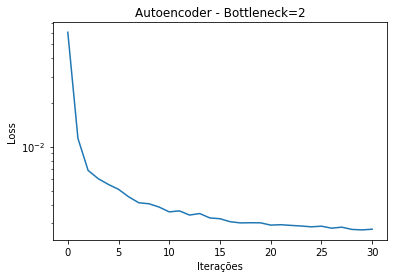

TypeError: ignored

In [172]:
loss_bottleneck2 = train_autoencoder("Autoencoder - Bottleneck=2", model_bottleneck2, input_tensor)

Epoch [0/15000], Loss: 0.062855
Epoch [500/15000], Loss: 0.007066
Epoch [1000/15000], Loss: 0.004319
Epoch [1500/15000], Loss: 0.003162
Epoch [2000/15000], Loss: 0.002879
Epoch [2500/15000], Loss: 0.002622
Epoch [3000/15000], Loss: 0.002503
Epoch [3500/15000], Loss: 0.002407
Epoch [4000/15000], Loss: 0.002386
Epoch [4500/15000], Loss: 0.002327
Epoch [5000/15000], Loss: 0.002262
Epoch [5500/15000], Loss: 0.002143
Epoch [6000/15000], Loss: 0.002074
Epoch [6500/15000], Loss: 0.002004
Epoch [7000/15000], Loss: 0.001807
Epoch [7500/15000], Loss: 0.001553
Epoch [8000/15000], Loss: 0.001385
Epoch [8500/15000], Loss: 0.001259
Epoch [9000/15000], Loss: 0.001171
Epoch [9500/15000], Loss: 0.001121
Epoch [10000/15000], Loss: 0.001078
Epoch [10500/15000], Loss: 0.001045
Epoch [11000/15000], Loss: 0.001040
Epoch [11500/15000], Loss: 0.000973
Epoch [12000/15000], Loss: 0.000936
Epoch [12500/15000], Loss: 0.000909
Epoch [13000/15000], Loss: 0.000946
Epoch [13500/15000], Loss: 0.000901
Epoch [14000/150

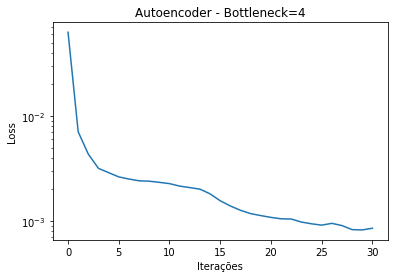

In [173]:
loss_bottleneck4 = train_autoencoder("Autoencoder - Bottleneck=4", model_bottleneck4, input_tensor)

Epoch [0/15000], Loss: 0.060647
Epoch [500/15000], Loss: 0.003310
Epoch [1000/15000], Loss: 0.001365
Epoch [1500/15000], Loss: 0.000933
Epoch [2000/15000], Loss: 0.000747
Epoch [2500/15000], Loss: 0.000600
Epoch [3000/15000], Loss: 0.000534
Epoch [3500/15000], Loss: 0.000430
Epoch [4000/15000], Loss: 0.000377
Epoch [4500/15000], Loss: 0.000369
Epoch [5000/15000], Loss: 0.000320
Epoch [5500/15000], Loss: 0.000294
Epoch [6000/15000], Loss: 0.000310
Epoch [6500/15000], Loss: 0.000241
Epoch [7000/15000], Loss: 0.000234
Epoch [7500/15000], Loss: 0.000220
Epoch [8000/15000], Loss: 0.000201
Epoch [8500/15000], Loss: 0.000202
Epoch [9000/15000], Loss: 0.000235
Epoch [9500/15000], Loss: 0.000181
Epoch [10000/15000], Loss: 0.000208
Epoch [10500/15000], Loss: 0.000159
Epoch [11000/15000], Loss: 0.000164
Epoch [11500/15000], Loss: 0.000146
Epoch [12000/15000], Loss: 0.000162
Epoch [12500/15000], Loss: 0.000145
Epoch [13000/15000], Loss: 0.000130
Epoch [13500/15000], Loss: 0.000158
Epoch [14000/150

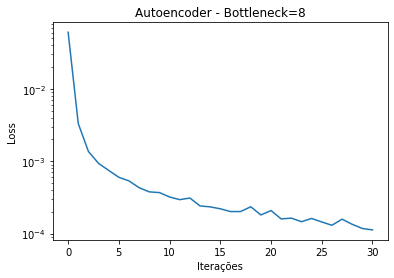

In [174]:
loss_bottleneck8 = train_autoencoder("Autoencoder - Bottleneck=8", model_bottleneck8, input_tensor)

In [ ]:
loss_bottleneck16 = train_autoencoder("Autoencoder - Bottleneck=16", model_bottleneck16, input_tensor)

Epoch [0/15000], Loss: 0.063436
Epoch [500/15000], Loss: 0.000807
Epoch [1000/15000], Loss: 0.000255
Epoch [1500/15000], Loss: 0.000117
Epoch [2000/15000], Loss: 0.000073
Epoch [2500/15000], Loss: 0.000077
Epoch [3000/15000], Loss: 0.000044
Epoch [3500/15000], Loss: 0.000034
Epoch [4000/15000], Loss: 0.000042
Epoch [4500/15000], Loss: 0.000026
Epoch [5000/15000], Loss: 0.000024
Epoch [5500/15000], Loss: 0.000022
Epoch [6000/15000], Loss: 0.000020
Epoch [6500/15000], Loss: 0.000036
Epoch [7000/15000], Loss: 0.000040
Epoch [7500/15000], Loss: 0.000029


0.023739805475284842 0.608362219827983


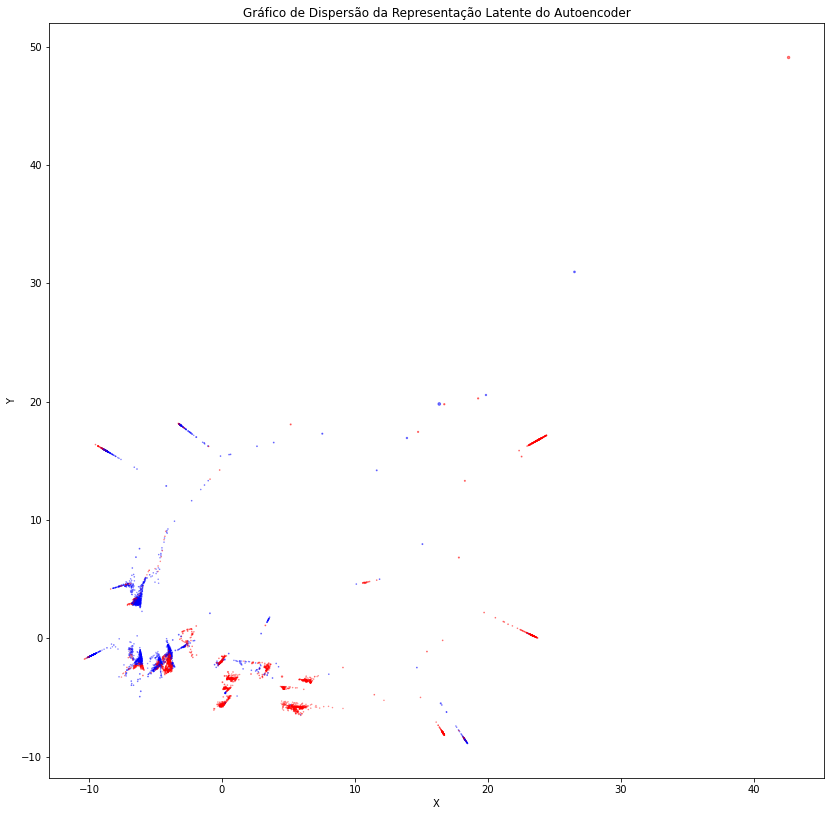

In [151]:
def show_latent_projection(model_name, model, inputs, bottleneck, dist_factor=6, dist_coef=2):
  
  input_tensor = torch.Tensor(inputs)
  latent = model.encoder(input_tensor).detach().numpy()
  output = model(input_tensor).detach().numpy()
  
  num_cols = latent.shape[] 
  if num_cols == 2:
    latent_2d = latent
  else:
    isomap = Isomap(n_components=2)
    latent_2d = isomap.fit_transform(latent)

  # cálcula a distância de reconstrução entre o dado de entrada e o dado de saída do autoencoder
  distances = np.linalg.norm(inputs - output, axis=1)
  min_dist, max_dist = min(distances), max(distances) 
  print(f"Min. Distance: {min_dist}")
  print(f"Max. Distance: {max_dist}")
  
  fig = plt.figure(figsize=(FIG_X/2, FIG_X/2))
  ax = fig.add_subplot(111)
  xs = latent_2d[:, 0]
  ys = latent_2d[:, 1]
  c = (data_df['lula_2t'] > data_df['bolsonaro_2t']).astype(float).map({1.0: 'red', 0.0: 'blue'}).to_list()
  # Set axis labels and title
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Gráfico de Dispersão da Representação Latente - ' + model_name)
  ax.scatter(xs, ys, c=c, s=(dist_factor*distances)**dist_coef, alpha=0.5)
  plt.show()

In [152]:
num_regioes = 5
num_estados = 27
num_campos_categoricos = num_regioes + num_estados
idx = num_campos_categoricos
std_reconstructed_df = pd.DataFrame({
    'id'                    : range(1, inputs.shape[0]+1)
,   'nr_latitude'           : pd.Series(output[:, idx + 0])
,   'nr_longitude'          : pd.Series(output[:, idx + 1])
,   'total_1t'              : pd.Series(output[:, idx + 2])
,   'total_2t'              : pd.Series(output[:, idx + 3])
,   'lula_1t'               : pd.Series(output[:, idx + 4])
,   'lula_2t'               : pd.Series(output[:, idx + 5])
,   'bolsonaro_1t'          : pd.Series(output[:, idx + 6])
,   'bolsonaro_2t'          : pd.Series(output[:, idx + 7])
,   'brancosnulos_1t'       : pd.Series(output[:, idx + 8])
,   'brancosnulos_2t'       : pd.Series(output[:, idx + 9])
,   'outros_1t'             : pd.Series(output[:, idx + 10])
,   'reconstruction_error'  : distances
})
#reconstructed_df.sort_values('reconstruction_error', inplace=True, ascending=False)
std_reconstructed_df

,id,nr_latitude,nr_longitude,total_1t,total_2t,lula_1t,lula_2t,bolsonaro_1t,bolsonaro_2t,brancosnulos_1t,brancosnulos_2t,outros_1t,reconstruction_error
0,1,0.147555,-0.178860,13.803505,13.796235,0.348895,0.370767,0.457257,0.638230,0.021381,0.003510,0.122057,0.608362
1,2,-0.002542,-0.473530,-0.112368,-0.113462,0.397766,0.410522,0.503200,0.562747,0.029262,0.028893,0.067176,0.056736
2,3,0.070607,-0.367589,-0.119091,-0.120912,0.305327,0.316762,0.594338,0.661004,0.028301,0.027196,0.070377,0.062625
3,4,-0.084346,-0.615901,-0.092109,-0.093426,0.427138,0.438300,0.475517,0.532998,0.029696,0.029483,0.065311,0.055624
4,5,0.039032,-0.588391,-0.166533,-0.168716,0.277880,0.285248,0.624331,0.693313,0.027401,0.026120,0.067708,0.062918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5566,-1.534059,-0.801828,-0.140186,-0.137929,0.268166,0.270759,0.612691,0.682948,0.035837,0.041744,0.078201,0.048787
5566,5567,-1.260057,-0.413918,0.136514,0.141145,0.235359,0.244568,0.648946,0.716029,0.035985,0.030447,0.070257,0.030035
5567,5568,-1.458878,-0.514959,-0.128924,-0.133615,0.191008,0.197898,0.710556,0.786610,0.030331,0.028430,0.071894,0.062127
5568,5569,-1.474798,-1.038082,-0.149468,-0.149789,0.431287,0.433420,0.457417,0.521479,0.032391,0.041793,0.072170,0.093054


In [153]:
sql = """
WITH cte_data AS (
  SELECT  a.id as id
  ,       ((a.nr_latitude      * b.stddev_nr_latitude       ) + b.avg_nr_latitude)        AS nr_latitude
  ,       ((a.nr_longitude     * b.stddev_nr_longitude      ) + b.avg_nr_longitude)       AS nr_longitude
  ,       ((a.total_1t         * b.stddev_total_1t          ) + b.avg_total_1t)           AS total_1t
  ,       ((a.total_2t         * b.stddev_total_2t          ) + b.avg_total_2t)           AS total_2t
  ,       a.lula_1t
  ,       a.lula_2t
  ,       a.bolsonaro_1t
  ,       a.bolsonaro_2t
  ,       a.brancosnulos_1t
  ,       a.brancosnulos_2t
  ,       a.outros_1t
  ,       a.reconstruction_error
  FROM    std_reconstructed_df a
          --
          CROSS JOIN std_df b
)
SELECT  a.id as id
,       a.nr_latitude
,       a.nr_longitude
,       a.total_1t
,       a.total_2t
,       a.total_1t * a.lula_1t as lula_1t
,       a.total_2t * a.lula_2t as lula_2t
,       a.total_1t * a.bolsonaro_1t as bolsonaro_1t
,       a.total_2t * a.bolsonaro_2t as bolsonaro_2t 
,       a.total_1t * a.brancosnulos_1t as brancosnulos_1t 
,       a.total_2t * a.brancosnulos_2t as brancosnulos_2t 
,       a.total_1t * a.outros_1t as outros_1t 
,       a.reconstruction_error
FROM    cte_data a
"""
reconstructed_df = con.execute(sql).fetchdf()
display(reconstructed_df)

,id,nr_latitude,nr_longitude,total_1t,total_2t,lula_1t,lula_2t,bolsonaro_1t,bolsonaro_2t,brancosnulos_1t,brancosnulos_2t,outros_1t,reconstruction_error
0,1,-15.233692,-47.380618,1.822065e+06,1.833366e+06,635708.502881,679752.200135,833151.681713,1.170110e+06,38957.329632,6435.933986,222395.777368,0.608362
1,2,-16.476488,-49.268596,7.497930e+03,7.356810e+03,2982.418404,3020.130478,3772.958722,4.140020e+03,219.407628,212.557416,503.680038,0.056736
2,3,-15.870817,-48.589821,6.621399e+03,6.378786e+03,2021.689628,2020.559617,3935.350840,4.216401e+03,187.392104,173.476153,465.996146,0.062625
3,4,-17.153814,-50.180779,1.013972e+04,9.987010e+03,4331.060107,4377.310230,4821.603118,5.323052e+03,301.107104,294.446645,662.237704,0.055624
4,5,-16.132254,-50.004523,4.351143e+02,1.032239e+02,120.909385,29.444415,271.655366,7.156644e+01,11.922781,2.696254,29.460619,0.062918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5566,-29.157333,-51.372031,3.870679e+03,4.144758e+03,1037.983008,1122.228624,2371.531209,2.830652e+03,138.712158,173.017097,302.690769,0.048787
5566,5567,-26.888619,-48.886655,3.995114e+04,4.078051e+04,9402.858012,9973.595016,25926.149691,2.920003e+04,1437.638292,1241.646620,2806.847420,0.030035
5567,5568,-28.534844,-49.534031,5.339218e+03,4.711122e+03,1019.831537,932.320280,3793.813912,3.705817e+03,161.942699,133.939312,383.858096,0.062127
5568,5569,-28.666659,-52.885732,2.660298e+03,2.587834e+03,1147.351940,1121.619383,1216.865266,1.349502e+03,86.169795,108.154437,191.993424,0.093054


In [154]:
def coord2xy(lng, lat):
  x = ((lng - MIN_LNG) / WIDTH) * (GRID_H_SIZE-1)
  y = ((lat - MIN_LAT) / HEIGHT) * (GRID_V_SIZE-1)
  return round(x), round(y)

def fill_meshes(df, reconstruction=False):
  lula_1t               = np.zeros(MAP_DIM)
  lula_2t               = np.zeros(MAP_DIM)
  bolsonaro_1t          = np.zeros(MAP_DIM)
  bolsonaro_2t          = np.zeros(MAP_DIM)
  outros_1t             = np.zeros(MAP_DIM) 
  brancosnulos_1t       = np.zeros(MAP_DIM)
  brancosnulos_2t       = np.zeros(MAP_DIM)
  total_1t              = np.zeros(MAP_DIM) 
  total_2t              = np.zeros(MAP_DIM)
  reconstruction_error  = np.zeros(MAP_DIM)
  counts                = np.zeros(MAP_DIM)

  # contabiliza os votos da eleição de 2022
  for row in df.itertuples():

      if not (MIN_LAT <= row.nr_latitude <= MAX_LAT and MIN_LNG <= row.nr_longitude <= MAX_LNG):
        # ignora pontos fora da bounding box do Brasil
        continue

      # obtém os índices da mesh grid
      x, y = coord2xy(row.nr_longitude, row.nr_latitude)    
      
      lula_1t[y, x]         += row.lula_1t
      lula_2t[y, x]         += row.lula_2t
      bolsonaro_1t[y, x]    += row.bolsonaro_1t
      bolsonaro_2t[y, x]    += row.bolsonaro_2t
      outros_1t[y, x]       += row.outros_1t
      brancosnulos_1t[y, x] += row.brancosnulos_1t
      brancosnulos_2t[y, x] += row.brancosnulos_2t
      total_1t[y, x]        += row.lula_1t + row.bolsonaro_1t + row.outros_1t + row.brancosnulos_1t
      total_2t[y, x]        += row.lula_2t + row.bolsonaro_2t + row.brancosnulos_2t
      counts[y, x]          += 1.0
      if reconstruction:
        reconstruction_error[y, x] += row.reconstruction_error

  lula_1t_pct               = lula_1t         / total_1t
  lula_2t_pct               = lula_2t         / total_2t
  bolsonaro_1t_pct          = bolsonaro_1t    / total_1t
  bolsonaro_2t_pct          = bolsonaro_2t    / total_2t
  outros_1t_pct             = outros_1t       / total_1t
  brancosnulos_1t_pct       = brancosnulos_1t / total_1t
  brancosnulos_2t_pct       = brancosnulos_2t / total_2t
  reconstruction_error      = reconstruction_error / counts
  
  # corrigindo células em que houve divisão por zero
  np.nan_to_num(lula_1t_pct,          copy=False, nan=0.0)
  np.nan_to_num(lula_2t_pct,          copy=False, nan=0.0)
  np.nan_to_num(bolsonaro_1t_pct,     copy=False, nan=0.0)
  np.nan_to_num(bolsonaro_2t_pct,     copy=False, nan=0.0)
  np.nan_to_num(outros_1t_pct,        copy=False, nan=0.0)
  np.nan_to_num(brancosnulos_1t_pct,  copy=False, nan=0.0)
  np.nan_to_num(brancosnulos_2t_pct,  copy=False, nan=0.0)
  np.nan_to_num(reconstruction_error, copy=False, nan=0.0)
  
  return {
    'lula_1t'               : lula_1t
  , 'lula_2t'               : lula_2t
  , 'bolsonaro_1t'          : bolsonaro_1t
  , 'bolsonaro_2t'          : bolsonaro_2t
  , 'outros_1t'             : outros_1t
  , 'brancosnulos_1t'       : brancosnulos_1t
  , 'brancosnulos_2t'       : brancosnulos_2t
  , 'total_1t'              : total_1t
  , 'total_2t'              : total_2t
  , 'lula_1t_pct'           : lula_1t_pct
  , 'lula_2t_pct'           : lula_2t_pct
  , 'bolsonaro_1t_pct'      : bolsonaro_1t_pct
  , 'bolsonaro_2t_pct'      : bolsonaro_2t_pct
  , 'outros_1t_pct'         : outros_1t_pct
  , 'brancosnulos_1t_pct'   : brancosnulos_1t_pct
  , 'brancosnulos_2t_pct'   : brancosnulos_2t_pct
  , 'reconstruction_error'  : reconstruction_error
  }


In [155]:
meshes = fill_meshes(data_df, reconstruction=False)
reconstructed_meshes = fill_meshes(reconstructed_df, reconstruction=True)
meshes['reconstruction_error'] = reconstructed_meshes['reconstruction_error']

<ipython-input-154-a12677cdf5a5>:42: RuntimeWarning: invalid value encountered in true_divide
  lula_1t_pct               = lula_1t         / total_1t
<ipython-input-154-a12677cdf5a5>:43: RuntimeWarning: invalid value encountered in true_divide
  lula_2t_pct               = lula_2t         / total_2t
<ipython-input-154-a12677cdf5a5>:44: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro_1t_pct          = bolsonaro_1t    / total_1t
<ipython-input-154-a12677cdf5a5>:45: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro_2t_pct          = bolsonaro_2t    / total_2t
<ipython-input-154-a12677cdf5a5>:46: RuntimeWarning: invalid value encountered in true_divide
  outros_1t_pct             = outros_1t       / total_1t
<ipython-input-154-a12677cdf5a5>:47: RuntimeWarning: invalid value encountered in true_divide
  brancosnulos_1t_pct       = brancosnulos_1t / total_1t
<ipython-input-154-a12677cdf5a5>:48: RuntimeWarning: invalid value encountered in true_divide


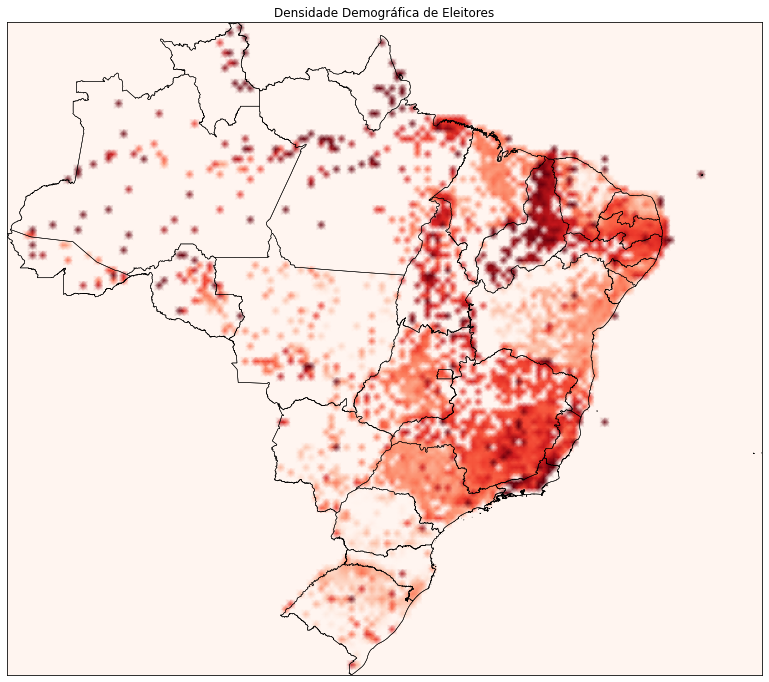

In [156]:
data = meshes['reconstruction_error']
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=False)
# vmin = 0
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 2), cmap="Reds", vmin=nth_root(vmin, 2), vmax=nth_root(vmax, 2))
plt.title("Densidade Demográfica de Eleitores")
plt.show()

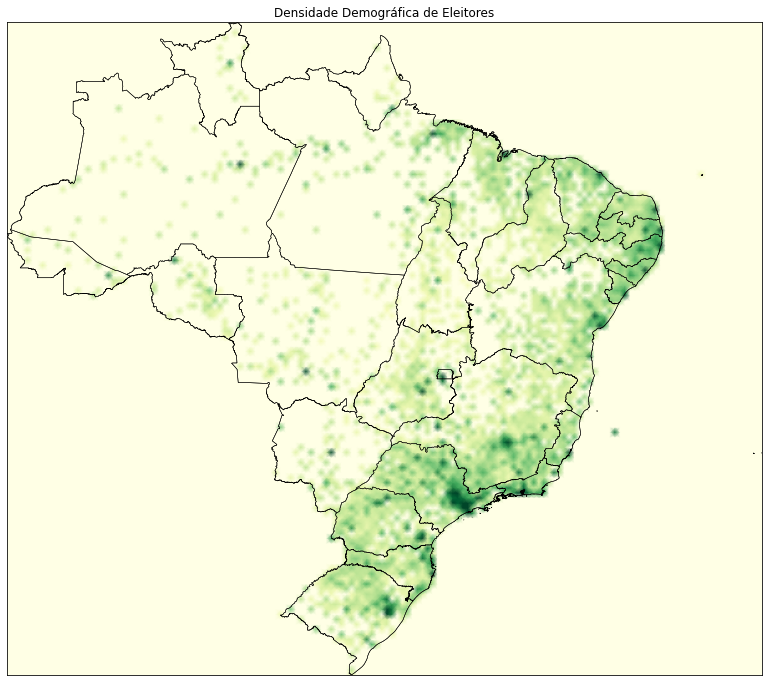

In [145]:
data = (meshes['total_1t'] + meshes['total_2t']) / 2
pcts = spatial_histogram(data)
p05 = pcts[ int(0.00 * len(pcts)) ]
p95 = pcts[ int(0.99 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data), cmap="YlGn", vmin=0, vmax=nth_root(vmax))
plt.title("Densidade Demográfica de Eleitores")
plt.show()

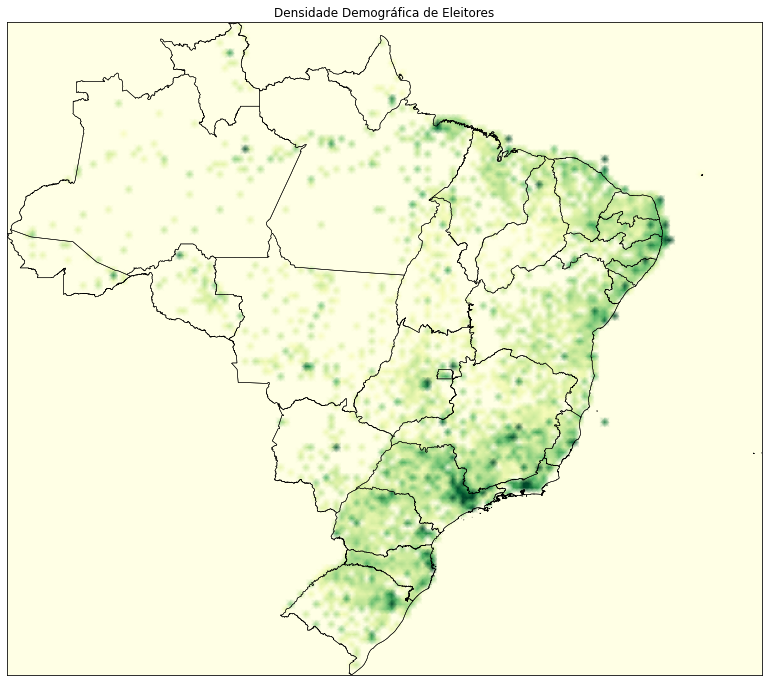

In [157]:
data = (reconstructed_meshes['total_1t'] + reconstructed_meshes['total_2t']) / 2
pcts = spatial_histogram(data)
p05 = pcts[ int(0.00 * len(pcts)) ]
p95 = pcts[ int(0.99 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data), cmap="YlGn", vmin=0, vmax=nth_root(vmax))
plt.title("Densidade Demográfica de Eleitores")
plt.show()

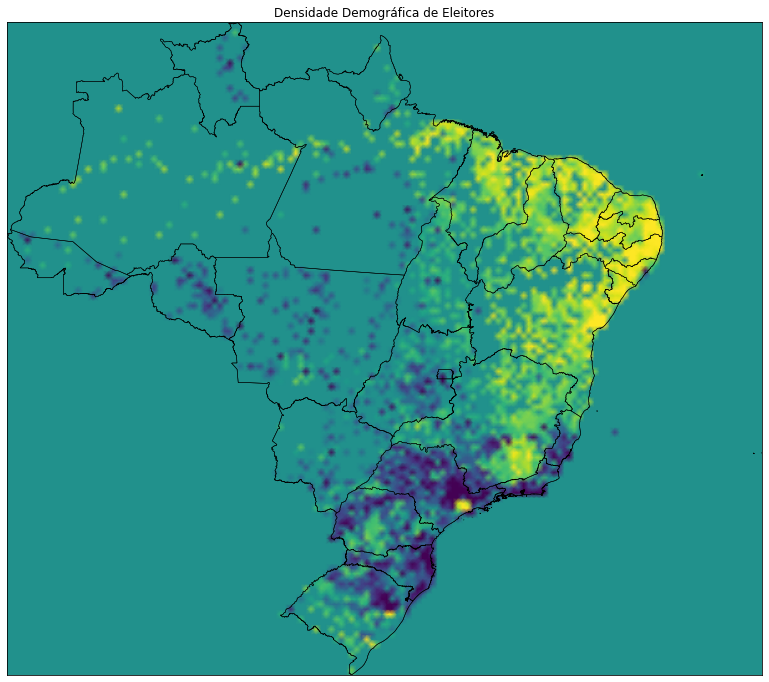

In [120]:
data = (meshes['lula_1t'] - meshes['bolsonaro_1t'])
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data), vmin=nth_root(vmin), vmax=nth_root(vmax))
plt.title("Densidade Demográfica de Eleitores")
plt.show()

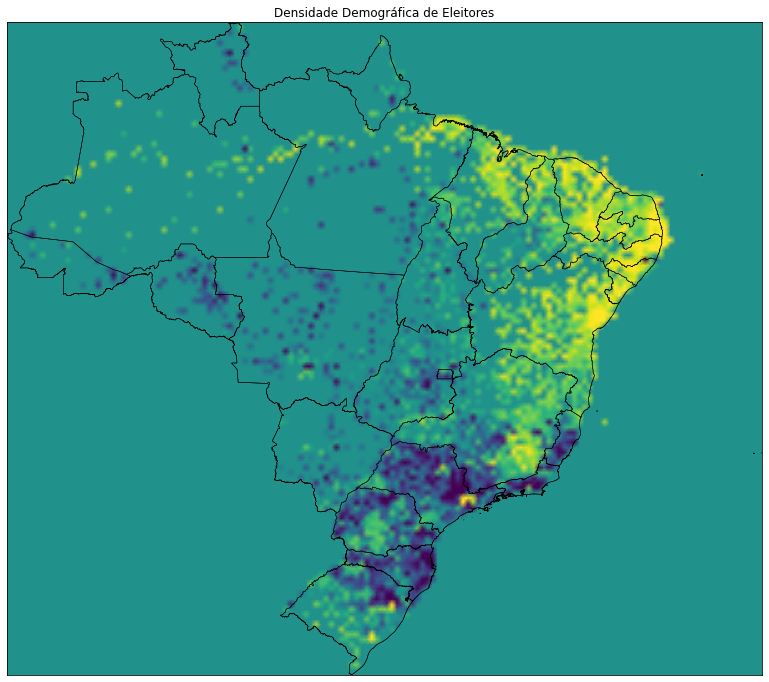

In [158]:
data = (reconstructed_meshes['lula_1t'] - reconstructed_meshes['bolsonaro_1t'])
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data), vmin=nth_root(vmin), vmax=nth_root(vmax))
plt.title("Densidade Demográfica de Eleitores")
plt.show()